# Import Model

In [4]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.act1  = nn.SiLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.shortcut = None
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        self.act2 = nn.SiLU()

    def forward(self, x):
        identity = x
        out = self.act1(self.bn1(self.conv1(x)))
        out = self.act2(self.bn2(self.conv2(out)))
        if self.shortcut is not None:
            identity = self.shortcut(x)
        return out + identity

class CenterSubtileEncoder(nn.Module):
    """專門處理中心 subtile 的 Encoder"""
    def __init__(self, out_dim, in_channels=3):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32), nn.SiLU(), nn.MaxPool2d(2)
        )  # 26→13
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 64), nn.MaxPool2d(2)
        )  # 13→6
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128)
        )  # 6×6

        # 多尺度池化
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.mid_pool    = nn.AdaptiveAvgPool2d((2,2))
        self.large_pool  = nn.AdaptiveAvgPool2d((3,3))

        total_dim = 128*1*1 + 128*2*2 + 128*3*3
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.1),
            nn.Linear(total_dim, out_dim*2),
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Linear(out_dim*2, out_dim),
            nn.SiLU(),
        )

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        g = self.global_pool(x).view(x.size(0), -1)
        m = self.mid_pool(x).view(x.size(0), -1)
        l = self.large_pool(x).view(x.size(0), -1)
        return self.fc(torch.cat([g, m, l], dim=1))

class NeighborSubtileEncoder(nn.Module):
    """共享權重，對多個鄰居 subtiles 做 mean pooling"""
    def __init__(self, out_dim, in_channels=3):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32), nn.SiLU(), nn.MaxPool2d(2)
        )  # h→13
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 64), nn.MaxPool2d(2)
        )  # 13→6
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128)
        )  # 6×6

        # 多尺度池化
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.mid_pool    = nn.AdaptiveAvgPool2d((2,2))
        self.large_pool  = nn.AdaptiveAvgPool2d((3,3))

        total_dim = 128*1*1 + 128*2*2  + 128*3*3
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.1),
            nn.Linear(total_dim, out_dim*2),
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Linear(out_dim*2, out_dim),
            nn.SiLU(),
        )

    def forward(self, subtiles):
        # subtiles: [B,9,3,26,26]
        B, N, C, H, W = subtiles.shape
        x = subtiles.view(B*N, C, H, W)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        g = self.global_pool(x).view(B, N, -1)
        m = self.mid_pool(x).view(B, N, -1)
        l = self.large_pool(x).view(B, N, -1)
        feats = torch.cat([g, m, l], dim=2)  # [B,N,total_dim]
        f = self.fc(feats.view(B*N, -1)).view(B, N, -1)
        return f.mean(dim=1)  # [B,out_dim]
                  # [B,out_dim]

class VisionMLP_MultiTask(nn.Module):
    """融合 Tile、Center、Neighbor 三路特徵的多任務模型"""
    def __init__(self, center_dim=64, neighbor_dim=64, output_dim=35):
        super().__init__()
        self.encoder_center    = CenterSubtileEncoder(center_dim)
        self.encoder_neighbors = NeighborSubtileEncoder(neighbor_dim)
        fusion_dim = center_dim + neighbor_dim
        self.decoder = nn.Sequential(
            nn.Linear(fusion_dim, 128), nn.SiLU(), nn.Dropout(0.1), nn.Linear(128, output_dim)
        )

    def forward(self, tile, subtiles):
        center = subtiles[:, 4]
        f_center = self.encoder_center(center)
        f_neigh = self.encoder_neighbors(subtiles)
        x = torch.cat([f_center, f_neigh], dim=1)
        return self.decoder(x)

# Instantiate and count parameters
model = VisionMLP_MultiTask( center_dim=64, neighbor_dim=64, output_dim=35)
print(f"Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.2f}M")


Params: 1.08M


## Load Model

# Import training data

## Same in multiple .pt

In [3]:
import os
import torch
import random
import inspect
from python_scripts.import_data import load_all_tile_data

# 用法範例
#folder = "dataset/spot-rank/version-3/only_tile_sub/original_train"

folder = "dataset/spot-rank/log2_nor_slide_min_spots/realgin/filtered/hed_normalize_image_masked/train_data/"
grouped_data = load_all_tile_data( 
        folder_path=folder,
        model=model,
        fraction=1,
        shuffle=False
    )

    # grouped_data 現在只會有 model.forward() 需要的 key，
    # 像 ['tile','subtiles','neighbors','norm_coord','node_feat','adj_list','edge_feat','label','source_idx']
print("Loaded keys:", grouped_data.keys())
print("Samples:", len(next(iter(grouped_data.values()))))


Loaded keys: dict_keys(['source_idx', 'tile', 'slide_idx', 'subtiles', 'label'])
Samples: 8348


In [5]:
import os
import torch
import csv
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from python_scripts.operate_model import train_one_epoch, evaluate, predict, plot_losses, plot_per_cell_metrics,spear_EarlyStopping
import torch.nn as nn

# ---------------------------
# 指定儲存資料夾
# ---------------------------
save_folder = "/Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/CNN+Res+MLP/log2_nor_slide_min_spots/k-fold/realign_all/hed_normalize_image_masked"  # 修改為你想要的資料夾名稱
if not os.path.exists(save_folder):
    os.makedirs(save_folder)


In [6]:
# --------------------------------------------
# 2) 從 grouped_data 取出 slide_idx，轉成 numpy
# --------------------------------------------
import numpy as np
slide_idx = np.array(grouped_data['slide_idx'])   # shape (N,)

# --------------------------------------------
# 3) 建立 LOGO（或改成 GroupKFold）
# --------------------------------------------
from sklearn.model_selection import LeaveOneGroupOut
logo = LeaveOneGroupOut()

# X 可以給虛擬矩陣，因為分組只靠 groups
X_dummy = np.zeros(len(slide_idx))
X_dummy

array([0., 0., 0., ..., 0., 0., 0.])

/Users/deweywang/Desktop/GitHub/HEVisum/python_scripts/aug.py:209: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


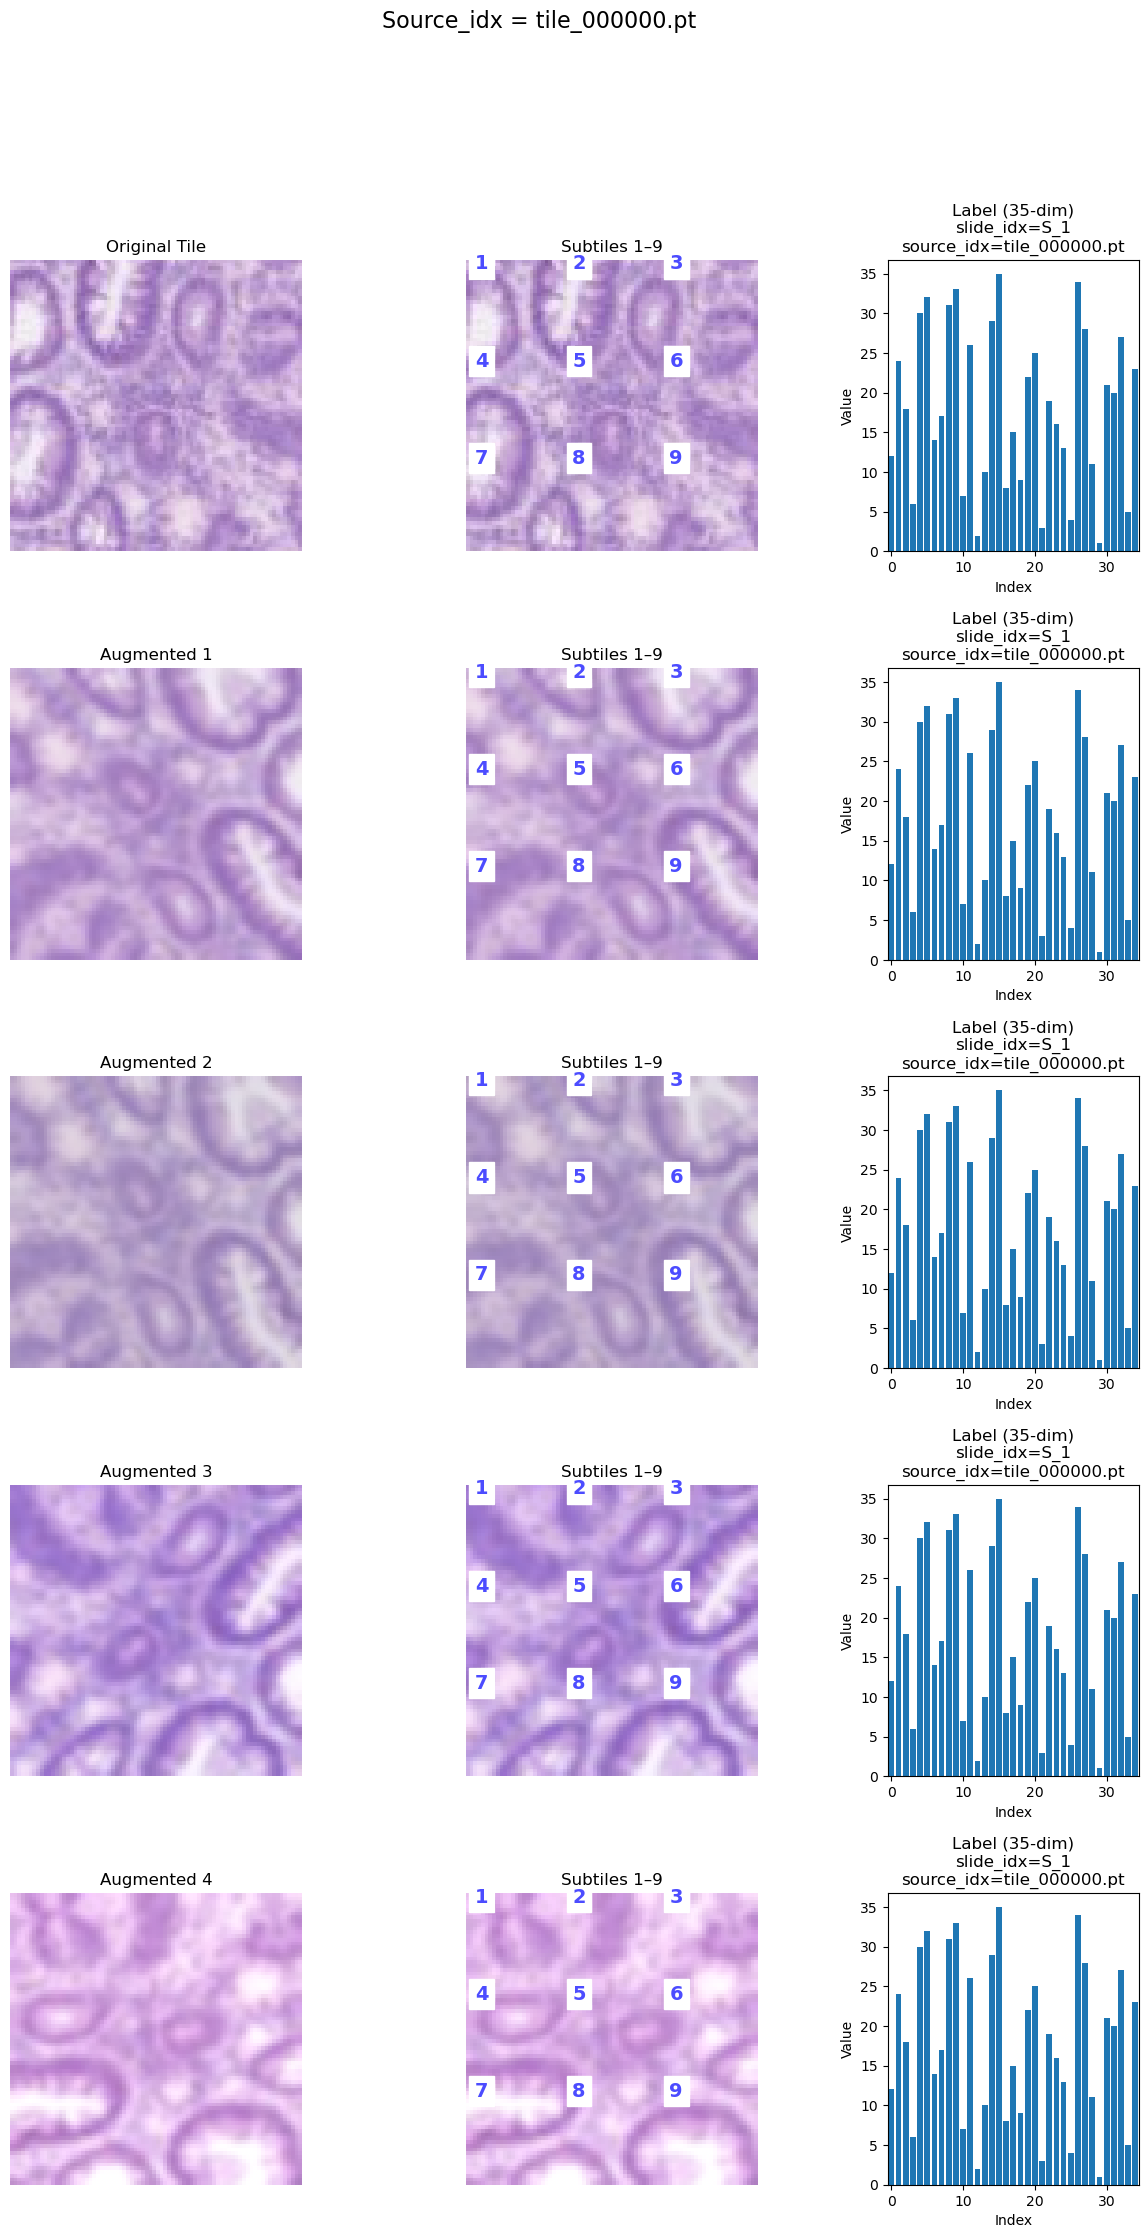

In [ ]:
from python_scripts.aug import plot_augmented_by_source

from python_scripts.aug import augment_grouped_data

# grouped_data: load_all_tile_data 返回的 dict
augmented_data = augment_grouped_data(
    grouped_data=grouped_data,
    image_keys=['tile','subtiles'],
    repeats=4   # 比如对每张做 2 次增强
)
source_ids = list(dict.fromkeys(grouped_data['source_idx']))  # 保持顺序去重

plot_augmented_by_source(source_ids[:1], augmented_data)


EarlyStopping counter: 10/10
[Epoch 19]  lr=4.07e-06, train_loss=10.7314, val_loss=24.6431
train spearman: 0.7836 | Val spearman: 0.4919 | best: 0.6461


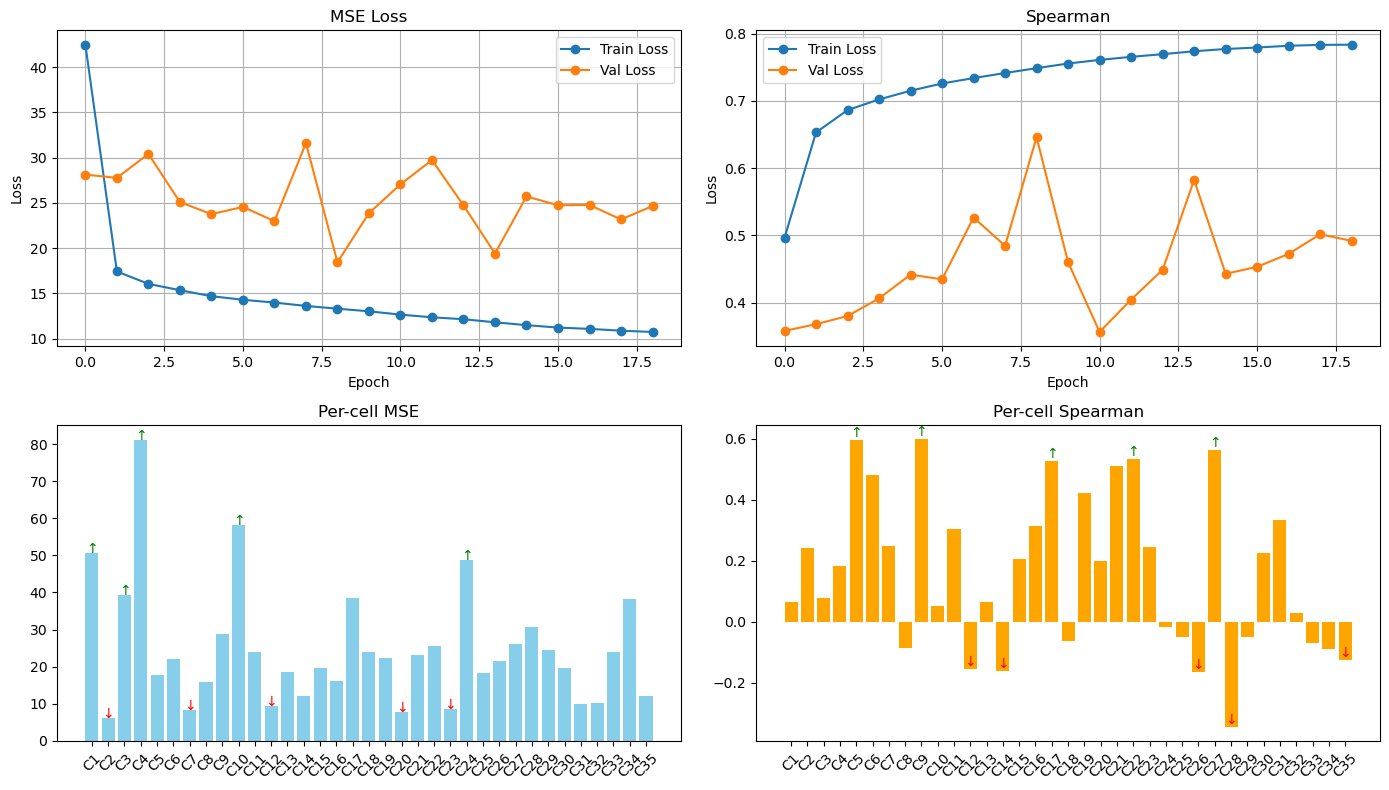

<Figure size 640x480 with 0 Axes>

曲線圖已儲存至 /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/CNN+Res+MLP/log2_nor_slide_min_spots/k-fold/realign_all/hed_normalize_image_masked/fold0/loss_curve.png
⛔ early stop
📈 Fold 0 best ρ = 0.6461
Starting fold 1
Starting subseting...
Starting augmenting...
Starting importDataset...
Starting DataLoader...
Starting model...


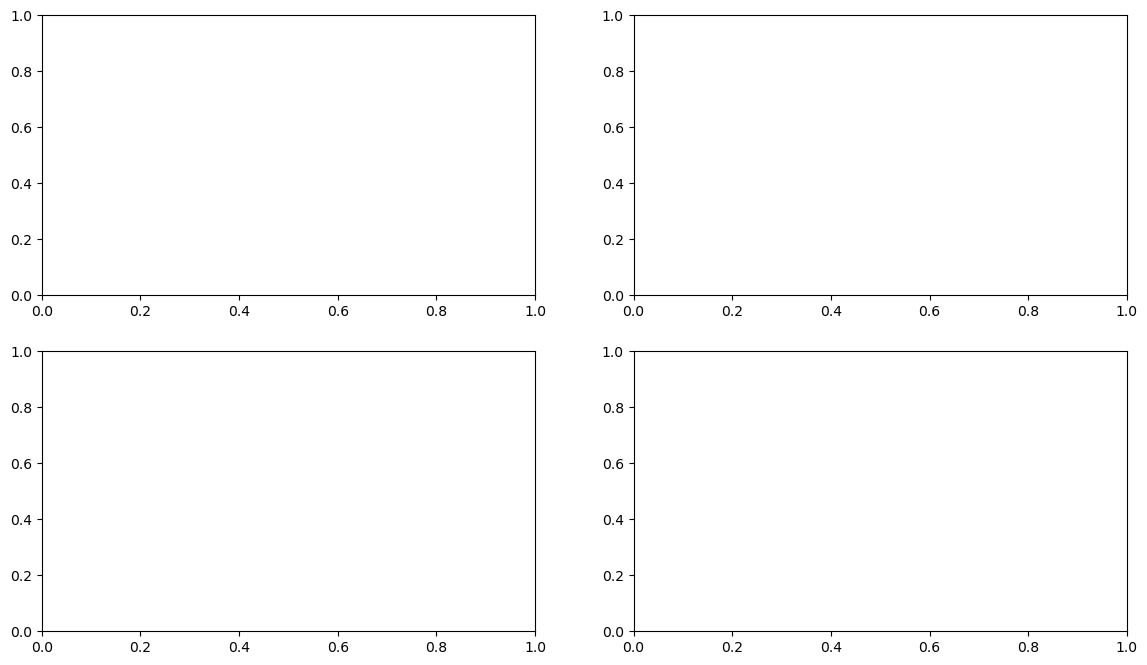

Starting training...


KeyboardInterrupt: 

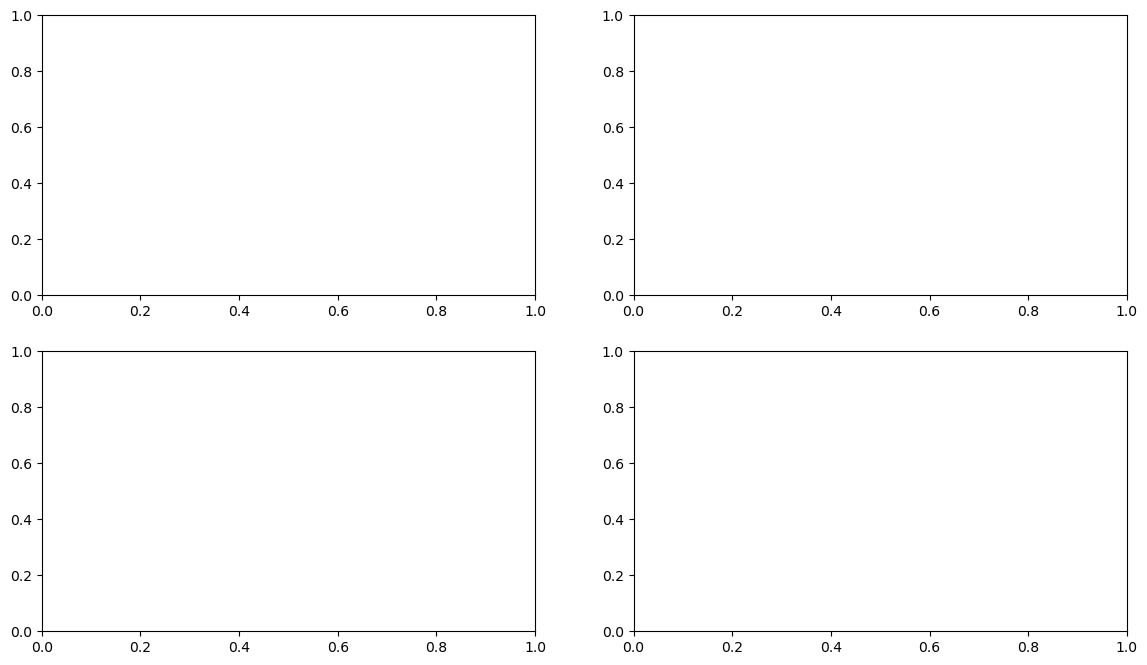

In [16]:
from torch.utils.data import DataLoader
from python_scripts.import_data import importDataset
from python_scripts.aug         import augment_grouped_data, identity, subset_grouped_data
import math
from torch.optim.lr_scheduler import LambdaLR
# ---------------- 基本參數 ----------------
start_fold = 0   # 从第几个 fold 开始训练（0-based），小于此值的 fold 会跳过

BATCH_SIZE   = 64
num_epochs   = 150
repeats      = 3
# ---------------- 參數設定 ----------------
save_root    = save_folder          # 最外層
os.makedirs(save_root, exist_ok=True)

# Seed once at the very top for reproducibility

logo     = LeaveOneGroupOut()
device   = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("✅ device:", device)

overall_best = []
# 在你的脚本文件头部



# ➋ LOGO / GroupKFold 切分索引，對 Dataset 建 Subset
for fold_id, (tr_idx, va_idx) in enumerate(
        logo.split(X=np.zeros(len(slide_idx)), y=None, groups=slide_idx)):
    
        # 如果当前 fold < start_fold，就跳过
    if fold_id < start_fold:
        print(f"⏭️ Skipping fold {fold_id}")
        continue
    
    print("Starting fold", fold_id)
    print("Starting subseting...")

    train_base = subset_grouped_data(grouped_data, tr_idx)
    print("Starting augmenting...")

    train_ds = augment_grouped_data(
                    grouped_data=train_base,
                    image_keys=['tile','subtiles'],
                    repeats=repeats   # 比如对每张做 2 次增强
                )
    print("Starting importDataset...")
    # 1) 原始 dataset
    train_ds = importDataset(train_ds, model,
                            image_keys=['tile','subtiles'],
                            transform=identity)


    # 3) validation raw
    val_ds     = subset_grouped_data(grouped_data, va_idx)
    val_ds     = importDataset(val_ds, model,
                            image_keys=['tile','subtiles'],
                            transform=identity)

    print("Starting DataLoader...")
    # 4) DataLoader 不再動態增強
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=0, pin_memory=False)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=0, pin_memory=False)

    # 5) 一切其餘步驟同之前：定模型、optimizer、train_one_epoch、evaluate……

    print("Starting model...")
    # ----- 新建模型 / 優化器 -----
    net = VisionMLP_MultiTask( center_dim=64, neighbor_dim=64, output_dim=35).to(device)

    # 我们把原来 Adam 换成 AdamW，稍微加一点 weight decay
    peak_lr       = 5e-4
    min_lr        = 1e-6
    warmup_epochs = 0
    total_epochs  = 20

    optimizer = torch.optim.AdamW(net.parameters(),
                                  lr=peak_lr,
                                  weight_decay=1e-3)

    # 定义 lr_lambda
    def lr_lambda(cur_epoch):
        if cur_epoch < warmup_epochs:
            # 线性 warm-up: 从 0 → 1
            return float(cur_epoch + 1) / warmup_epochs
        else:
            # 余弦退火：从 1 → min_lr/peak_lr
            progress = (cur_epoch - warmup_epochs) / (total_epochs - warmup_epochs)
            # cos(0)=1 → cos(pi)=−1, remap to [min_ratio,1]
            min_ratio = min_lr / peak_lr
            return min_ratio + 0.5 * (1 - min_ratio) * (1 + math.cos(math.pi * progress))

    scheduler = LambdaLR(optimizer, lr_lambda)

    stopper = spear_EarlyStopping(patience=10)

    # ----- fold 專屬輸出路徑 -----
    fold_dir  = os.path.join(save_folder, f"fold{fold_id}")
    os.makedirs(fold_dir, exist_ok=True)
    best_model_path = os.path.join(fold_dir, "best_model.pt")
    loss_plot_path  = os.path.join(fold_dir, "loss_curve.png")
    csv_path        = os.path.join(fold_dir, "training_log.csv")

    # ----- CSV log -----
    log_f = open(csv_path, "w", newline="")
    csv_w = csv.writer(log_f)
    csv_w.writerow(["Epoch","TrainLoss","ValLoss","ValSpearman","LR"])

    # ----- 圖形 -----
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    display(fig)

    train_losses = []; val_losses = []
    train_rhos   = []; val_rhos   = []

    best_rho = -1.0
    print("Starting training...")
    for epoch in range(num_epochs):
        tloss, trho = train_one_epoch(
            net, train_loader, optimizer, device,
            current_epoch=epoch, initial_alpha=0, final_alpha=0, target_epoch=20)

        vloss, vrho, mse_cell, rho_cell = evaluate(
            net, val_loader, device,
            current_epoch=epoch, initial_alpha=0, final_alpha=0, target_epoch=20)

        clear_output(wait=True)  # 清除之前的輸出
        axes[0][0].clear()
        axes[0][1].clear()
        axes[1][0].clear()
        axes[1][1].clear()
        # --- save best ---
        if vrho > best_rho:
            best_rho = vrho
            torch.save(net.state_dict(), best_model_path)
            print(f"✅ Saved best model in {best_model_path}!")

        # --- scheduler / early stop ---
        scheduler.step()
        stopper(vrho)


    
        # --- logging ---
        lr = optimizer.param_groups[0]['lr']
        csv_w.writerow([epoch+1, tloss, vloss, vrho, lr])

        train_losses.append(tloss); val_losses.append(vloss)
        train_rhos.append(trho);   val_rhos.append(vrho)
        

        

        # 印出 Epoch 結果
        lr = optimizer.param_groups[0]['lr']
        print(f"[Epoch {epoch+1}]  lr={lr:.2e}, train_loss={tloss:.4f}, val_loss={vloss:.4f}")
        print(f"train spearman: {trho:.4f} | Val spearman: {vrho:.4f} | best: {best_rho:.4f}")
        # --- update plots ---
        plot_losses(train_losses, val_losses, axes[0][0], "MSE Loss")
        plot_losses(train_rhos,   val_rhos,   axes[0][1], "Spearman")
        cell_names = [f"C{i+1}" for i in range(35)]
        plot_per_cell_metrics(mse_cell, rho_cell, cell_names,
                              ax_mse=axes[1][0], ax_spearman=axes[1][1])
        plt.tight_layout(); display(fig); plt.pause(0.1)
        fig.savefig(loss_plot_path)
        print(f"曲線圖已儲存至 {loss_plot_path}")
        if stopper.early_stop:
            print("⛔ early stop"); break

    log_f.close(); plt.close(fig)
    overall_best.append(best_rho) 
    print(f"📈 Fold {fold_id} best ρ = {best_rho:.4f}")

# ========= 整體結果 =========
overall_best = np.array(overall_best)
print("\n=========== CV summary ===========")
for i, r in enumerate(overall_best):
    print(f"fold {i}: best ρ = {r:.4f}")
print(f"overall best (mean) ρ = {overall_best.mean():.4f} ± {overall_best.std():.4f}")

In [8]:
import os
import numpy as np
import joblib
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from scipy.stats import rankdata
from python_scripts.import_data import importDataset
from python_scripts.operate_model import predict

full_dataset = importDataset(grouped_data, model,
                             image_keys=['tile','subtiles'],
                             transform=lambda x: x)
# ---------------- Settings ----------------
save_root  = save_folder  # your save_folder path
n_folds    = len([d for d in os.listdir(save_root) if d.startswith('fold')])
n_samples  = len(full_dataset)
C          = 35  # num cell types
start_fold = 0
BATCH_SIZE = 64
# If optimizing Spearman, convert labels to ranks
use_rank   = False

# --- 1) Prepare OOF meta-features ---
# Initialize matrix for OOF predictions
n_samples = len(full_dataset)
oof_preds = np.zeros((n_samples, C), dtype=np.float32)
# True labels (raw or rank)
# importDataset returns a dict-like sample, so label is under key 'label'
y_true = np.vstack([ full_dataset[i]['label'].cpu().numpy() for i in range(n_samples) ])
if use_rank:
    y_meta = np.apply_along_axis(rankdata, 1, y_true)
else:
    y_meta = y_true

# Build CV splitter (must match first stage splits)
logo = LeaveOneGroupOut()

# Loop over folds, load best model, predict on validation indices
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
for fold_id, (tr_idx, va_idx) in enumerate(
        logo.split(X=np.zeros(n_samples), y=None, groups=slide_idx)):
    # Load model
    if fold_id > start_fold:
        print(f"⏭️ Skipping fold {fold_id}")
        continue
    ckpt_path = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    print(f"Loading model from {ckpt_path}...")
    net = VisionMLP_MultiTask( center_dim=64, neighbor_dim=64, output_dim=35).to(device)
    # Alternatively, if your model requires specific args, replace with:
    # net = VisionMLP_MultiTask(tile_dim=64, subtile_dim=64, output_dim=35).to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.to(device).eval()

    # Predict on validation set
    val_ds = Subset(full_dataset, va_idx)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    preds = predict(net, val_loader, device)  # (n_val, C)
    oof_preds[va_idx] = preds
    print(f"Fold {fold_id}: OOF preds shape {preds.shape}")

# --- 2) Train LightGBM meta-model ---
# Choose objective: regression on rank (for Spearman) or raw (for MSE)
lgb_base = lgb.LGBMRegressor(
    objective='regression',
    learning_rate=0.001,
    n_estimators=1000,
    num_leaves=31,
    subsample=0.7,
    colsample_bytree=0.7,
    n_jobs=-1,
    force_col_wise=True
)
meta_model = MultiOutputRegressor(lgb_base)
print("Training LightGBM on OOF meta-features...")
meta_model.fit(oof_preds, y_meta)
# Save meta-model
joblib.dump(meta_model, os.path.join(save_root, 'meta_model.pkl'))

# --- 3) Prepare test meta-features ---
n_test = len(test_dataset)
test_meta = np.zeros((n_test, C), dtype=np.float32)
for fold_id in range(n_folds):
    ckpt_path = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    net = VisionMLP_MultiTask( center_dim=64, neighbor_dim=64, output_dim=35).to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.to(device).eval()
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    preds = predict(net, test_loader, device)
    test_meta += preds
# Average across folds
test_meta /= n_folds

# --- 4) Meta-model predict ---
if use_rank:
    final_preds = meta_model.predict(test_meta) / (C + 1)
else:
    final_preds = meta_model.predict(test_meta)

# --- Save submission ---
import h5py
import pandas as pd
with h5py.File("./dataset/elucidata_ai_challenge_data.h5","r") as f:
    test_spot_ids = pd.DataFrame(np.array(f["spots/Test"]["S_7"]))
sub = pd.DataFrame(final_preds, columns=[f"C{i+1}" for i in range(C)])
sub.insert(0, 'ID', test_spot_ids.index)
sub.to_csv(os.path.join(save_root, 'submission_stacked.csv'), index=False)
print("✅ Saved stacked submission.")


Loading model from /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/CNN+Res+MLP/log2_nor_slide_min_spots/k-fold/realign_all/hed_normalize_image_masked/fold0/best_model.pt...
Fold 0: OOF preds shape (2197, 35)
⏭️ Skipping fold 1
⏭️ Skipping fold 2
⏭️ Skipping fold 3
⏭️ Skipping fold 4
⏭️ Skipping fold 5
Training LightGBM on OOF meta-features...
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 8348, number of used features: 35
[LightGBM] [Info] Start training from score 25.598758
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 8348, number of used features: 35
[LightGBM] [Info] Start training from score 24.933037
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 8348, number of used features: 35
[LightGBM] [Info] Start training from score 25.533447
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set:

NameError: name 'test_dataset' is not defined

In [12]:
import os
import numpy as np
import joblib
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from scipy.stats import rankdata
from python_scripts.import_data import importDataset
from python_scripts.operate_model import predict

# --- 配置: 只用哪些 fold 的结果来训练/预测 meta-model ---
meta_folds = [0]  # 例如只用 fold0, fold2, fold4

# 1) 准备 full_dataset, slide_idx, test_dataset 等
full_dataset = importDataset(
    grouped_data, model,
    image_keys=['tile','subtiles'],
    transform=lambda x: x
)
n_samples = len(full_dataset)
C = 35  # 类别数

# 2) 预留 oof_preds 和 fold_ids
oof_preds    = np.zeros((n_samples, C), dtype=np.float32)
oof_fold_ids = np.full(n_samples, -1, dtype=int)

# 真标签
y_true = np.vstack([ full_dataset[i]['label'].cpu().numpy() for i in range(n_samples) ])
y_meta = y_true.copy()  # 不做 rank 时直接用 raw

# 3) 生成 OOF 预测并记录 fold id
logo = LeaveOneGroupOut()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

for fold_id, (tr_idx, va_idx) in enumerate(
        logo.split(X=np.zeros(n_samples), y=None, groups=slide_idx)):

    # 如果当前 fold 不在我们想要的 meta_folds 列表里，就跳过
    if fold_id not in meta_folds:
        print(f"⏭️ Skipping OOF for fold {fold_id}")
        continue

    print(f"\n>>> Generating OOF for fold {fold_id}")
    ckpt_path = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    net = VisionMLP_MultiTask(center_dim=64, neighbor_dim=64, output_dim=C).to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.eval()

    val_loader = DataLoader(Subset(full_dataset, va_idx), batch_size=BATCH_SIZE, shuffle=False)
    preds = predict(net, val_loader, device)  # (n_val, C)

    oof_preds[va_idx]    = preds
    oof_fold_ids[va_idx] = fold_id

    print(f"  → Fold {fold_id} OOF preds shape: {preds.shape}")
# 4) 只选取 meta_folds 的行来训练 meta-model
mask = np.isin(oof_fold_ids, meta_folds)
X_meta = oof_preds[mask]
y_meta_sub = y_meta[mask]

print(f"\nTraining meta-model on folds {meta_folds}:")
print(f"  使用样本数：{X_meta.shape[0]} / {n_samples}")

lgb_base = lgb.LGBMRegressor(
    objective='regression',
    learning_rate=0.001,
    n_estimators=1000,
    num_leaves=31,
    subsample=0.7,
    colsample_bytree=0.7,
    n_jobs=-1,
    force_col_wise=True
)
meta_model = MultiOutputRegressor(lgb_base)
meta_model.fit(X_meta, y_meta_sub)
joblib.dump(meta_model, os.path.join(save_root, 'meta_model.pkl'))

# 5) 准备 test_meta，只平均 meta_folds 中的预测
n_folds = len([d for d in os.listdir(save_root) if d.startswith('fold')])
n_test  = len(test_dataset)
test_meta = np.zeros((n_test, C), dtype=np.float32)

for fold_id in range(n_folds):
    if fold_id not in meta_folds:
        continue
    ckpt_path = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    net = VisionMLP_MultiTask(center_dim=64, neighbor_dim=64, output_dim=C).to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.eval()

    loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    preds = predict(net, loader, device)
    test_meta += preds

# 平均时除以参与的 folds 数目
test_meta /= len(meta_folds)

# 6) 用 meta-model 做最终预测
final_preds = meta_model.predict(test_meta)

# --- Save submission ---
import h5py
import pandas as pd

with h5py.File("./dataset/elucidata_ai_challenge_data.h5","r") as f:
    test_spot_ids = pd.DataFrame(np.array(f["spots/Test"]["S_7"]))

sub = pd.DataFrame(final_preds, columns=[f"C{i+1}" for i in range(C)])
sub.insert(0, 'ID', test_spot_ids.index)
sub.to_csv(os.path.join(save_root, 'submission_stacked.csv'), index=False)
print("✅ Saved stacked submission.")



>>> Generating OOF for fold 0
  → Fold 0 OOF preds shape: (2197, 35)
⏭️ Skipping OOF for fold 1
⏭️ Skipping OOF for fold 2
⏭️ Skipping OOF for fold 3
⏭️ Skipping OOF for fold 4
⏭️ Skipping OOF for fold 5

Training meta-model on folds [0]:
  使用样本数：2197 / 8348
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 2197, number of used features: 35
[LightGBM] [Info] Start training from score 25.614138
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 2197, number of used features: 35
[LightGBM] [Info] Start training from score 26.330779
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 2197, number of used features: 35
[LightGBM] [Info] Start training from score 25.874389
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 2197, number of used features: 35
[LightGBM] [Info] Start training from score 22.126159
[LightGBM] [Info] To

/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature na

✅ Saved stacked submission.


In [ ]:
docs_rel.max()

35

In [65]:
import os
import numpy as np
import joblib
from scipy.stats import rankdata
import lightgbm as lgb
from sklearn.model_selection import LeaveOneGroupOut
from torch.utils.data import DataLoader, Subset
from python_scripts.import_data import importDataset
from python_scripts.operate_model import predict


# --- 配置 ---
meta_folds = [0]      # 只用哪些 fold 的 OOF 结果
C          = 35       # cell type 数量
BATCH_SIZE = 64

# 1) 导入 full_dataset, slide_idx, test_dataset
full_dataset = importDataset(grouped_data, model,
                             image_keys=['tile','subtiles'],
                             transform=lambda x: x)
n_spots = len(full_dataset)

# 2) 生成 OOF preds & 记录 fold id (同你之前做法)
oof_preds    = np.zeros((n_spots, C), dtype=np.float32)
oof_fold_ids = np.full(n_spots, -1, dtype=int)
logo = LeaveOneGroupOut()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

for fold_id, (tr_idx, va_idx) in enumerate(
        logo.split(X=np.zeros(n_spots), y=None, groups=slide_idx)):
    if fold_id not in meta_folds:
        continue
    # load CNN model & predict
    ckpt = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    net  = VisionMLP_MultiTask(center_dim=64, neighbor_dim=64, output_dim=C).to(device)
    net.load_state_dict(torch.load(ckpt, map_location=device))
    net.eval()
    loader = DataLoader(Subset(full_dataset, va_idx),
                        batch_size=BATCH_SIZE, shuffle=False)
    preds = predict(net, loader, device)  # (n_val, C)
    oof_preds[va_idx]    = preds
    oof_fold_ids[va_idx] = fold_id

# 真标签矩阵 (n_spots, C)
y_true = np.vstack([ full_dataset[i]['label'].cpu().numpy()
                     for i in range(n_spots) ])

# 3) 筛出 meta_folds 的行
mask       = np.isin(oof_fold_ids, meta_folds)
X_meta     = oof_preds[mask]    # (N_meta, C)
y_meta     = y_true[mask]       # (N_meta, C)
slides_sub = slide_idx[mask]    # (N_meta,)

N_meta = X_meta.shape[0]

docs_feat = X_meta.reshape(-1, 1)   # 变成 (N_meta * 35, 1)

# 对应的真实 abundance，也要 flatten
docs_true = y_meta.reshape(-1,)     # (N_meta * 35,)

# 每个 spot 里对 35 个 abundance 做 ordinal 排，即 relevance label
docs_rel = np.zeros_like(docs_true, dtype=int)
for i in range(X_meta.shape[0]):
    start = i * C
    end   = start + C
    docs_rel[start:end] = rankdata(
        docs_true[start:end],
        method='ordinal'
    ) - 1          # 变成 0‐based

# Flatten 之后的 group：每个 spot 下固定 35 条 doc
train_group = [C] * X_meta.shape[0]  # e.g. [35,35,35, ...] 长度 = N_meta

# ------------------------ 2) 训练一个 LGBMRanker ------------------------
ranker = lgb.LGBMRanker(
    objective='lambdarank',
    metric='ndcg@35',      # 也可以只关注 ndcg@5、@10
    label_gain=list(range(docs_rel.max()+1)),
    learning_rate=1e-3,
    n_estimators=1000,
    num_leaves=31,
    subsample=0.7,
    colsample_bytree=0.7,
    n_jobs=-1
)
ranker.fit(
    docs_feat,   # (N_meta*35, 1)
    docs_rel,    # (N_meta*35,)
    group=train_group
)

# ------------------------ 3) 测试时同样 Flatten + Predict ------------------------
# 5) 准备 test_meta，只平均 meta_folds 中的预测
n_folds = len([d for d in os.listdir(save_root) if d.startswith('fold')])
n_test  = len(test_dataset)
test_meta = np.zeros((n_test, C), dtype=np.float32)

for fold_id in range(n_folds):
    if fold_id not in meta_folds:
        continue
    ckpt_path = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    net = VisionMLP_MultiTask(center_dim=64, neighbor_dim=64, output_dim=C).to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.eval()

    loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    preds = predict(net, loader, device)
    test_meta += preds

# 平均时除以参与的 folds 数目
test_meta /= len(meta_folds)

docs_test_feat = test_meta.reshape(-1, 1)     # (n_test*35, 1)
test_group     = [C] * test_meta.shape[0]    # [35, 35, ..., 35]

docs_test_score = ranker.predict(docs_test_feat, group=test_group)  # (n_test*35,)

# 把分数 reshape 回 (n_test, 35)
scores = docs_test_score.reshape(test_meta.shape[0], C)  


final_scores = test_meta*scores
# 6) 写入 submission
import pandas as pd, h5py


with h5py.File("./dataset/elucidata_ai_challenge_data.h5","r") as f:
    test_spot_ids = pd.DataFrame(np.array(f["spots/Test"]["S_7"]))

sub = pd.DataFrame(final_scores, columns=[f"C{i+1}" for i in range(C)])
sub.insert(0, 'ID', test_spot_ids.index)
sub.to_csv(os.path.join(save_root, 'submission_LGBMRanker.csv'), index=False)
print("✅ Saved stacked submission.")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 76895, number of used features: 1


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


✅ Saved stacked submission.


# Predict

In [9]:
import torch
import inspect
from python_scripts.operate_model import get_model_inputs

def load_node_feature_data(pt_path: str, model, num_cells: int = 35) -> dict:
    """
    根据 model.forward 的参数自动加载 .pt 里对应的字段，
    并且如果没有 label，就自动创建一个全 0 的 label 张量，
    其尺寸为 (样本数, num_cells)，样本数从第一个有 __len__ 的输入推断。

    参数：
      pt_path:     str，.pt 文件路径
      model:       已实例化的 PyTorch 模型
      num_cells:   int，label 的列数（默认 35）

    返回：
      dict: key 对应模型 forward 中的参数名（不含 self），
            value 是对应的 Tensor/ndarray，
            并额外保证有 'label' 字段。
    """
    # 1) 载入原始数据
    raw = torch.load(pt_path, map_location="cpu")

    # 2) 取模型 forward 入参签名（不含 self）
    sig = inspect.signature(model.forward)
    param_names = [p for p in sig.parameters if p != "self"]

    out = {}
    for name in param_names:
        # a) 直接同名
        if name in raw:
            out[name] = raw[name]
            continue
        # b) 复数形式
        if name + "s" in raw:
            out[name] = raw[name + "s"]
            continue
        # c) 模糊匹配（下划线、复数或前后缀）
        cands = [k for k in raw if name in k or k in name]
        if len(cands) == 1:
            out[name] = raw[cands[0]]
            continue
        raise KeyError(f"无法找到 '{name}' 在 pt 文件中的对应字段，raw keys: {list(raw.keys())}")

    # 3) 用第一个支持 len() 的输入推断样本数
    dataset_size = None
    for v in out.keys():
        if hasattr(out[v], "__len__"):
            dataset_size = len(out[v])
            print(f"⚠️ 从 '{v}' 推断样本数量: {dataset_size}")
            break
    if dataset_size is None:
        raise RuntimeError("无法从任何输入中推断样本数量，请检查 pt 文件内容。")

    # 4) 自动补 label

    out["label"] = torch.zeros((dataset_size, num_cells), dtype=torch.float32)
    return out


image_keys = [ 'tile', 'subtiles']


# 用法示例
from python_scripts.import_data import importDataset
# 假设你的 model 已经定义好并实例化为 `model`
test_dataset = load_node_feature_data("dataset/spot-rank/test/hed_normalize_image_masked/test_dataset.pt", model)
test_dataset = importDataset(
        data_dict=test_dataset,
        model=model,
        image_keys=image_keys,
        transform=lambda x: x,  # identity transform
        print_sig=True
    )



⚠️ 从 'tile' 推断样本数量: 2088
Model forward signature: (tile, subtiles)


In [ ]:

test_dataset.check_item(1000, 10)


In [10]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [22]:
import glob
import torch
import numpy as np
import pandas as pd
import os
import h5py
from torch.utils.data import DataLoader

# 讀 test spot index
with h5py.File("./dataset/elucidata_ai_challenge_data.h5","r") as f:
    test_spots     = f["spots/Test"]
    test_spot_table= pd.DataFrame(np.array(test_spots['S_7']))

fold_ckpts = sorted(glob.glob(os.path.join(save_folder, "fold*", "best_model.pt")))
models = []
for ckpt in fold_ckpts:
    net = VisionMLP_MultiTask(center_dim=64, neighbor_dim=64, output_dim=35).to(device)
    net.load_state_dict(torch.load(ckpt, map_location="cpu"))
    net.to(device).eval()
    models.append(net)

all_fold_preds = []
for fold_id, net in enumerate(models):
    # 推論
    with torch.no_grad():
        preds = predict(net, test_loader, device)  # (N_test,35) numpy array

    # 1) 存每一折的原始預測
    df_fold = pd.DataFrame(preds, columns=[f"C{i+1}" for i in range(preds.shape[1])])
    df_fold.insert(0, "ID", test_spot_table.index)
    path_fold = os.path.join(save_folder, f"submission_fold{fold_id}.csv")
    df_fold.to_csv(path_fold, index=False)
    print(f"✅ Saved fold {fold_id} predictions to {path_fold}")

    all_fold_preds.append(preds)

# 2) 做 rank‐average ensemble
all_fold_preds = np.stack(all_fold_preds, axis=0)       # (K, N_test, 35)
ranks          = all_fold_preds.argsort(axis=2).argsort(axis=2).astype(float)
mean_rank      = ranks.mean(axis=0)                    # (N_test,35)

# 3) 存 final ensemble
df_ens = pd.DataFrame(mean_rank, columns=[f"C{i+1}" for i in range(mean_rank.shape[1])])
df_ens.insert(0, "ID", test_spot_table.index)
path_ens = os.path.join(save_folder, "submission_rank_ensemble.csv")
df_ens.to_csv(path_ens, index=False)
print(f"✅ Saved rank‐ensemble submission to {path_ens}")


✅ Saved fold 0 predictions to /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/CNN+Res+MLP/log2_nor_slide_min_spots/k-fold/realign_all/hed_normalize_image_masked/submission_fold0.csv
✅ Saved rank‐ensemble submission to /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/CNN+Res+MLP/log2_nor_slide_min_spots/k-fold/realign_all/hed_normalize_image_masked/submission_rank_ensemble.csv
